# Deep Convolutional Generative Adversarial Network (DCGAN) Tutorial

This tutorials walks through an implementation of DCGAN as described in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

To learn more about generative adversarial networks, see my [Medium post](https://medium.com/p/54deab2fce39) on them.

In [5]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

We will be using the MNIST dataset. input_data is a library that downloads the dataset and uzips it automatically. It can be acquired Github here: https://gist.github.com/awjuliani/1d21151bc17362bf6738c3dc02f37906

In [6]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 28, 28)
(55000,)


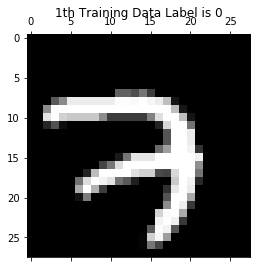

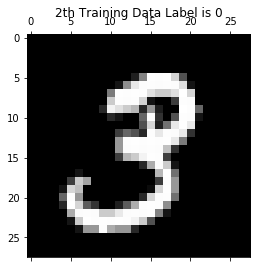

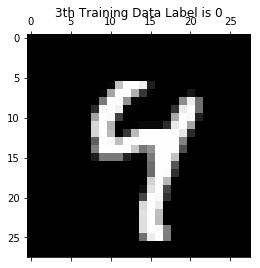

In [7]:
#print out several data in mnist
trainimg = mnist.train.images
train_y = mnist.train.labels
nsample = 1
randidx = np.random.randint(trainimg.shape[0], size=nsample)

train_x = np.reshape(trainimg,(trainimg.shape[0],28,28))
print(train_x.shape)
print(train_y.shape)

for i in [0, 1, 2]:
    curr_img   = np.reshape(trainimg[i, :], (28, 28)) # 28 by 28 matrix 
    curr_label = np.argmax(train_y[i] ) # Label
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title("" + str(i + 1) + "th Training Data " 
              + "Label is " + str(curr_label))

### Helper Functions

In [8]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

## Defining the Adversarial Networks

### Generator Network

The generator takes a vector of random numbers and transforms it into a 32x32 image. Each layer in the network involves a strided  transpose convolution, batch normalization, and rectified nonlinearity. Tensorflow's slim library allows us to easily define each of these layers.

In [79]:
def generator(z, c):
    
    c_flat = tf.layers.Flatten()(c)
    zcP = tf.concat([z, c_flat],1)
    
    
    g_in = slim.fully_connected(zcP,4*4*256,normalizer_fn= slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    
    g_in_Con = tf.reshape(g_in,[-1,4,4,256])
    
    
    gen1 = slim.convolution2d_transpose(\
        g_in_Con,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    print(g_out.shape)
    
    return g_out

### Discriminator Network
The discriminator network takes as input a 32x32 image and transforms it into a single valued probability of being generated from real-world data. Again we use tf.slim to define the convolutional layers, batch normalization, and weight initialization.

In [84]:
def discriminator(img, c, reuse=False):
    
    print(img.shape)
    print(c.shape)
    print("//")
    dis_img_1 = slim.convolution2d(img,16,[4,4],stride=[2,2],padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv1',weights_initializer=initializer)
    dis_c_1 = slim.convolution2d(c,16,[4,4],stride=[2,2],padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='d_c_conv1',weights_initializer=initializer)
    '''
    dis2 = slim.convolution2d(dis1,32,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv2', weights_initializer=initializer)
    
    dis3 = slim.convolution2d(dis2,64,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv3',weights_initializer=initializer)
    '''
    d_img_out = slim.fully_connected(slim.flatten(dis_img_1),64,activation_fn=tf.nn.relu,\
        reuse=reuse,scope='d_img_out', weights_initializer=initializer)
    d_c_out = slim.fully_connected(slim.flatten(dis_c_1),64,activation_fn=tf.nn.relu,\
        reuse=reuse,scope='d_c_out', weights_initializer=initializer)
    
    fc1 = tf.concat([d_img_out, d_c_out],1)
    d_out =  slim.fully_connected(slim.flatten(fc1),1,activation_fn=tf.nn.sigmoid,\
        reuse=reuse,scope='d_out', weights_initializer=initializer)

    return d_out

### Connecting them together

In [86]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
c_in = tf.placeholder(shape = [None,32,32,1],dtype = tf.float32) # conditional input
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

Gz = generator(z_in, c_in) #Generates images from random z vectors
Dx = discriminator(real_in, c_in) #Produces probabilities for real images
Dg = discriminator(Gz,c_in,reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

(?, 32, 32, 1)
(?, 32, 32, 1)
(?, 32, 32, 1)
//
(?, 32, 32, 1)
(?, 32, 32, 1)
//


## Training the network
Now that we have fully defined our network, it is time to train it!

In [89]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 500000 #Total number of iterations to use.
sample_directory = './CDCGANfigs' #Directory to save sample images from generator in.
model_directory = './CDCGANmodels' #Directory to save trained model to.

saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs, c_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs, c_in:xs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs, c_in:xs})
        
        '''
        
        '''
        if i % 10 == 0:
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2, c_in:xs}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")

Gen Loss: 0.68830794 Disc Loss: 1.3891736


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Gen Loss: 0.69389987 Disc Loss: 1.3865371
Gen Loss: 0.6907045 Disc Loss: 1.3897834
Gen Loss: 0.6940279 Disc Loss: 1.3853979
Gen Loss: 0.691639 Disc Loss: 1.3910112
Gen Loss: 0.69688416 Disc Loss: 1.380646
Gen Loss: 0.7089751 Disc Loss: 1.3552366
Gen Loss: 0.77050304 Disc Loss: 1.2604753
Gen Loss: 0.43596888 Disc Loss: 1.8995246
Gen Loss: 0.69646144 Disc Loss: 1.4107133
Gen Loss: 0.70298356 Disc Loss: 1.3791263
Gen Loss: 0.70265317 Disc Loss: 1.3955126
Gen Loss: 0.6456228 Disc Loss: 1.35392
Gen Loss: 0.6911453 Disc Loss: 1.4032626
Gen Loss: 0.6945557 Disc Loss: 1.3932977
Gen Loss: 0.70031005 Disc Loss: 1.3763602
Gen Loss: 0.6931244 Disc Loss: 1.3927217
Gen Loss: 0.6925979 Disc Loss: 1.392101
Gen Loss: 0.6887018 Disc Loss: 1.4027785
Gen Loss: 0.6977637 Disc Loss: 1.3843098
Gen Loss: 0.6963022 Disc Loss: 1.3825601
Gen Loss: 0.6925084 Disc Loss: 1.4019432
Gen Loss: 0.6982346 Disc Loss: 1.386613
Gen Loss: 0.7001039 Disc Loss: 1.393843
Gen Loss: 0.6851486 Disc Loss: 1.412164
Gen Loss: 0.6923

Gen Loss: 0.69137144 Disc Loss: 1.3916886
Saved Model
Gen Loss: 0.69422853 Disc Loss: 1.3858912
Gen Loss: 0.69651246 Disc Loss: 1.3809104
Gen Loss: 0.69843084 Disc Loss: 1.3763251
Gen Loss: 0.69460654 Disc Loss: 1.3946321
Gen Loss: 0.69973266 Disc Loss: 1.3748715
Gen Loss: 0.69688284 Disc Loss: 1.3911616
Gen Loss: 0.6971364 Disc Loss: 1.3818791
Gen Loss: 0.69122154 Disc Loss: 1.3905009
Gen Loss: 0.69416296 Disc Loss: 1.3834028
Gen Loss: 0.6908132 Disc Loss: 1.3945336
Gen Loss: 0.6931323 Disc Loss: 1.3892963
Gen Loss: 0.69371355 Disc Loss: 1.3860514
Gen Loss: 0.6921449 Disc Loss: 1.3913442
Gen Loss: 0.6908519 Disc Loss: 1.3952012
Gen Loss: 0.69420964 Disc Loss: 1.3856604
Gen Loss: 0.6975477 Disc Loss: 1.3792555
Gen Loss: 0.70250607 Disc Loss: 1.3679837
Gen Loss: 0.68771404 Disc Loss: 1.4057934
Gen Loss: 0.6965061 Disc Loss: 1.3822758
Gen Loss: 0.7018073 Disc Loss: 1.3712354
Gen Loss: 0.68857116 Disc Loss: 1.4041699
Gen Loss: 0.6931025 Disc Loss: 1.389252
Gen Loss: 0.6989893 Disc Loss: 1

Gen Loss: 0.75736386 Disc Loss: 1.3125408
Gen Loss: 0.7806827 Disc Loss: 1.3420634
Saved Model
Gen Loss: 0.7913213 Disc Loss: 1.2449596
Gen Loss: 0.6918181 Disc Loss: 1.443482
Gen Loss: 0.8003328 Disc Loss: 1.2283832
Gen Loss: 0.63508666 Disc Loss: 1.5273585
Gen Loss: 0.68154585 Disc Loss: 1.4141388
Gen Loss: 0.6363598 Disc Loss: 1.5667435
Gen Loss: 0.6969967 Disc Loss: 1.4290779
Gen Loss: 0.6671199 Disc Loss: 1.4623396
Gen Loss: 0.71322334 Disc Loss: 1.3703623
Gen Loss: 0.6767567 Disc Loss: 1.4796152
Gen Loss: 0.7332372 Disc Loss: 1.2950633
Gen Loss: 0.7416771 Disc Loss: 1.3570256
Gen Loss: 0.72162354 Disc Loss: 1.4182429
Gen Loss: 0.687133 Disc Loss: 1.4269631
Gen Loss: 0.70421296 Disc Loss: 1.4197963
Gen Loss: 0.7471038 Disc Loss: 1.328436
Gen Loss: 0.7140495 Disc Loss: 1.3359778
Gen Loss: 0.7836055 Disc Loss: 1.2607393
Gen Loss: 0.7041075 Disc Loss: 1.4914914
Gen Loss: 0.6802443 Disc Loss: 1.4588816
Gen Loss: 0.6552013 Disc Loss: 1.4396523
Gen Loss: 0.6581388 Disc Loss: 1.4742856
G

Gen Loss: 1.0573884 Disc Loss: 0.94918317
Gen Loss: 0.6364206 Disc Loss: 1.5522293
Gen Loss: 0.649357 Disc Loss: 1.4971743
Saved Model
Gen Loss: 0.724348 Disc Loss: 1.3893864
Gen Loss: 0.6919738 Disc Loss: 1.4321823
Gen Loss: 0.7511515 Disc Loss: 1.2824154
Gen Loss: 0.73674464 Disc Loss: 1.3717452
Gen Loss: 0.82516474 Disc Loss: 1.2515912
Gen Loss: 0.6928131 Disc Loss: 1.4337959
Gen Loss: 0.7848569 Disc Loss: 1.242173
Gen Loss: 0.74177146 Disc Loss: 1.3699461
Gen Loss: 0.7789142 Disc Loss: 1.2926131
Gen Loss: 0.8588 Disc Loss: 1.1582332
Gen Loss: 0.8109052 Disc Loss: 1.2852753
Gen Loss: 0.89786005 Disc Loss: 1.025532
Gen Loss: 0.5976474 Disc Loss: 1.5351663
Gen Loss: 0.8045201 Disc Loss: 1.1929926
Gen Loss: 0.804762 Disc Loss: 1.298633
Gen Loss: 0.75096524 Disc Loss: 1.2469985
Gen Loss: 0.730705 Disc Loss: 1.308641
Gen Loss: 0.7007909 Disc Loss: 1.4887979
Gen Loss: 0.8048172 Disc Loss: 1.2124287
Gen Loss: 0.9280665 Disc Loss: 1.2002469
Gen Loss: 0.95522773 Disc Loss: 1.1074086
Gen Loss

Gen Loss: 1.0024402 Disc Loss: 1.0906537
Gen Loss: 0.90100145 Disc Loss: 1.2592301
Gen Loss: 1.1443319 Disc Loss: 0.98285156
Gen Loss: 0.8215074 Disc Loss: 1.4432495
Saved Model
Gen Loss: 0.7992187 Disc Loss: 1.062444
Gen Loss: 1.2186761 Disc Loss: 0.9304035
Gen Loss: 0.8787674 Disc Loss: 1.3406912
Gen Loss: 1.5559711 Disc Loss: 0.5129785
Gen Loss: 1.3165828 Disc Loss: 0.6770245
Gen Loss: 1.5032082 Disc Loss: 0.59459865
Gen Loss: 1.2545028 Disc Loss: 0.9786785
Gen Loss: 0.40632325 Disc Loss: 3.1154923
Gen Loss: 1.2814169 Disc Loss: 0.8566958
Gen Loss: 0.7037898 Disc Loss: 1.1955562
Gen Loss: 0.7182567 Disc Loss: 1.4480157
Gen Loss: 1.0331936 Disc Loss: 1.003111
Gen Loss: 0.92486405 Disc Loss: 1.228148
Gen Loss: 0.93282545 Disc Loss: 1.2028477
Gen Loss: 0.7893822 Disc Loss: 1.4915345
Gen Loss: 0.9987251 Disc Loss: 1.3491124
Gen Loss: 1.0612108 Disc Loss: 0.9798697
Gen Loss: 1.064238 Disc Loss: 1.0228109
Gen Loss: 0.7358339 Disc Loss: 1.583911
Gen Loss: 1.1134278 Disc Loss: 1.0221238
Gen

Gen Loss: 0.759938 Disc Loss: 1.3365281
Gen Loss: 0.6827011 Disc Loss: 1.5371606
Gen Loss: 0.92681044 Disc Loss: 1.1035191
Gen Loss: 0.87831277 Disc Loss: 1.1560967
Gen Loss: 0.7611102 Disc Loss: 1.2849616
Saved Model
Gen Loss: 0.78852415 Disc Loss: 1.3856788
Gen Loss: 0.92076635 Disc Loss: 1.1398218
Gen Loss: 1.0523453 Disc Loss: 0.9095418
Gen Loss: 1.0604268 Disc Loss: 0.954324
Gen Loss: 0.56676483 Disc Loss: 2.0069737
Gen Loss: 1.1452739 Disc Loss: 0.94373524
Gen Loss: 0.77479273 Disc Loss: 1.3679459
Gen Loss: 0.62884736 Disc Loss: 1.7802746
Gen Loss: 1.0816095 Disc Loss: 0.9854312
Gen Loss: 1.2089243 Disc Loss: 0.80785537
Gen Loss: 1.488889 Disc Loss: 0.5925215
Gen Loss: 1.656277 Disc Loss: 0.45818847
Gen Loss: 0.749002 Disc Loss: 1.4458678
Gen Loss: 0.71021855 Disc Loss: 1.4854252
Gen Loss: 0.62730545 Disc Loss: 1.6810776
Gen Loss: 0.56728494 Disc Loss: 1.8458505
Gen Loss: 0.6361406 Disc Loss: 1.6255366
Gen Loss: 0.7879378 Disc Loss: 1.3450919
Gen Loss: 0.8867948 Disc Loss: 1.1696

Gen Loss: 0.9074469 Disc Loss: 1.0609739
Gen Loss: 0.9198387 Disc Loss: 1.2088312
Gen Loss: 0.9991252 Disc Loss: 1.1643431
Gen Loss: 0.7917694 Disc Loss: 1.3904569
Gen Loss: 0.7035321 Disc Loss: 1.6409004
Gen Loss: 0.83441895 Disc Loss: 1.3532962
Saved Model
Gen Loss: 1.1762083 Disc Loss: 1.2123605
Gen Loss: 1.0088532 Disc Loss: 1.2469879
Gen Loss: 1.2679718 Disc Loss: 0.80648154
Gen Loss: 1.0970814 Disc Loss: 1.0589557
Gen Loss: 0.95330006 Disc Loss: 1.2923294
Gen Loss: 0.6305063 Disc Loss: 1.7873483
Gen Loss: 0.82391006 Disc Loss: 1.4337025
Gen Loss: 1.1518941 Disc Loss: 0.8241776
Gen Loss: 1.1374667 Disc Loss: 0.9001373
Gen Loss: 0.8281247 Disc Loss: 1.0329378
Gen Loss: 1.0976422 Disc Loss: 1.1588738
Gen Loss: 1.1155415 Disc Loss: 0.9585097
Gen Loss: 1.250243 Disc Loss: 0.7286284
Gen Loss: 0.84312236 Disc Loss: 1.3911941
Gen Loss: 0.93357825 Disc Loss: 1.2472101
Gen Loss: 0.55481946 Disc Loss: 2.0557804
Gen Loss: 0.7176522 Disc Loss: 1.5777302
Gen Loss: 1.0714185 Disc Loss: 1.041504

Gen Loss: 0.70124817 Disc Loss: 1.5869023
Gen Loss: 0.7187092 Disc Loss: 1.498436
Gen Loss: 0.50055003 Disc Loss: 2.0917425
Gen Loss: 0.7585918 Disc Loss: 1.461059
Gen Loss: 1.0272427 Disc Loss: 0.9765278
Gen Loss: 0.96405274 Disc Loss: 1.1410348
Gen Loss: 0.8665427 Disc Loss: 1.0024085
Gen Loss: 1.1451402 Disc Loss: 0.8668878
Saved Model
Gen Loss: 1.1754856 Disc Loss: 0.7536688
Gen Loss: 0.73589176 Disc Loss: 1.4869044
Gen Loss: 1.0241697 Disc Loss: 1.0836906
Gen Loss: 1.0579455 Disc Loss: 1.0581551
Gen Loss: 0.9458731 Disc Loss: 1.3616663
Gen Loss: 1.0999631 Disc Loss: 1.4033644
Gen Loss: 1.1532909 Disc Loss: 1.1907496
Gen Loss: 0.24719647 Disc Loss: 1.9147636
Gen Loss: 4.49517 Disc Loss: 0.03540604
Gen Loss: 3.0417604 Disc Loss: 0.7151067
Gen Loss: 1.6318784 Disc Loss: 0.55797136
Gen Loss: 1.0934161 Disc Loss: 0.895334
Gen Loss: 0.592941 Disc Loss: 1.5213017
Gen Loss: 0.8975787 Disc Loss: 1.4212105
Gen Loss: 1.0911677 Disc Loss: 0.96309507
Gen Loss: 1.1764859 Disc Loss: 0.87823653
G

KeyboardInterrupt: 

## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [ ]:
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
batch_size_sample = 36

init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print 'Loading Model...'
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    zs = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')